El objetivo de este proyecto es poder entrenar un modelo que sea capaz de reconocer las diferentes razas de perro

Importaremos las siguientes librerías que nos ayudarán a completar el proyecto

In [1]:
from fastai.vision.all import *
from fastdownload import download_url
from fastai.callback.mixup import CutMix

from torchvision.models import resnet18

from time import sleep
import matplotlib.pyplot as plt
import time
import gradio as gr

C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path
import shutil
import os

import random

Usaremos el conjunto de datos de Kaggle Dog Breeds que se encuentra descargado localmente en la siguiente dirección

In [3]:
dataset_path = Path(r"\\wsl.localhost\Ubuntu\home\uai2001\dog_breeds\images\Images")

output_path = Path(r"\\wsl.localhost\Ubuntu\home\uai2001\dog_classifier\dataset_split")

En esta dirección están las imágenes de cada raza de perro, pero no están separadas en bloques de entrenamiento, testeo y validación, por lo que vamos a tener que hacer esa separación de forma manual

Vamos a empezar con la separación manual de estas imágenes

In [ ]:
for folder in ["train", "test", "valid"]:
    (output_path/folder).mkdir(parents=True, exist_ok=True)

In [ ]:
# Obtener todas las carpetas de clases
class_folders = [d for d in dataset_path.iterdir() if d.is_dir()]

In [ ]:
# Iterar sobre cada clase y dividir imágenes en train, test y valid
for class_folder in class_folders:
    images = list(class_folder.glob("*.jpg"))  # Ajusta si hay PNG u otro formato
    random.shuffle(images)  # Mezclar imágenes aleatoriamente
    
    # Dividir en porcentajes
    num_images = len(images)
    train_split = int(num_images * 0.7)
    test_split = int(num_images * 0.2)

    train_images = images[:train_split]
    test_images = images[train_split:train_split + test_split]
    valid_images = images[train_split + test_split:]

    # Crear carpetas para cada clase dentro de train, test y valid
    for folder in ["train", "test", "valid"]:
        (output_path/folder/class_folder.name).mkdir(parents=True, exist_ok=True)

    # Mover imágenes a sus carpetas respectivas
    for img in train_images:
        shutil.move(str(img), str(output_path/"train"/class_folder.name/img.name))

    for img in test_images:
        shutil.move(str(img), str(output_path/"test"/class_folder.name/img.name))

    for img in valid_images:
        shutil.move(str(img), str(output_path/"valid"/class_folder.name/img.name))

print("✅ División completada. Imágenes organizadas en train, test y valid por clase.")

Ya teniendo nuestros datos separados podemos empezar el entrenamiento de nuestro modelo, pero como el conjunto de datos es muy grande y queremos tiempos de ejecución medianamente reducidos emplearemos el 20% de nuestros datos para realizar el entrenamiento

In [4]:
all_files = get_image_files(output_path/"train")

# Tomar solo el 20% de los datos
subset_size = int(len(all_files) * 0.2)
subset_files = all_files[:subset_size]

# Definir un nuevo DataBlock con menos datos
small_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: subset_files,  # Usar solo el subconjunto de imágenes
    splitter=None,
    get_y=parent_label,
    item_tfms=[Resize(299, method='squish')],
    batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=30, max_zoom=1.1), Normalize.from_stats(*imagenet_stats)]
).dataloaders(output_path/"train", bs=32)

Comprobamos que el DataSet esté correctamente definido

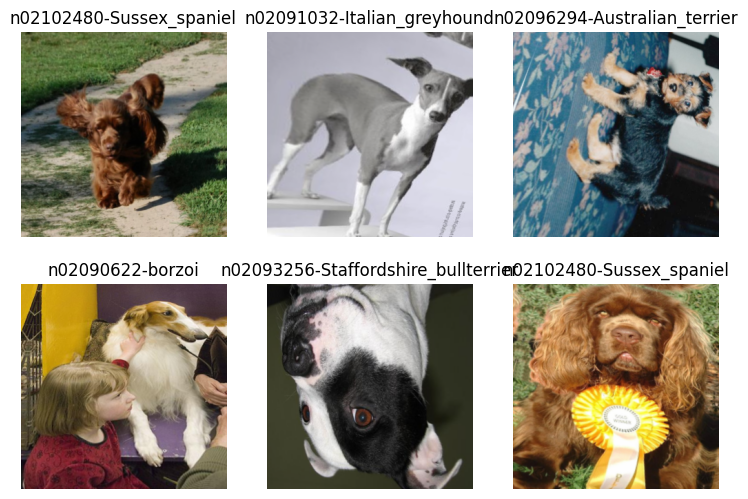

In [5]:
small_dls.show_batch(max_n=6)

Aplicaremos el método CutMix para evitar el sobreajuste y mejorar la precisión

In [6]:
learn = vision_learner(small_dls, resnet18, metrics=accuracy, loss_func=CrossEntropyLossFlat()).to_fp16()

learn.add_cb(CutMix(alpha=1.0))

In [7]:
learn.fine_tune(5, base_lr=1e-3, wd=1e-2)

C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,3.843268,0.729045,0.780488,06:22


epoch,train_loss,valid_loss,accuracy,time
0,2.997015,0.523775,0.850174,11:58
1,2.651636,0.389592,0.885017,10:02
2,2.645359,0.415708,0.885017,10:18
3,2.598623,0.378955,0.898955,10:04
4,2.437718,0.384304,0.898955,09:27


In [8]:
learn = vision_learner(small_dls, resnet18, metrics=accuracy).to_fp16()

learn.fit_one_cycle(3, lr_max=slice(1e-5, 1e-3), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.619407,0.456011,0.857143,07:28
1,1.459115,0.318562,0.897213,07:25
2,1.092493,0.302343,0.888502,07:17


In [9]:
learn.export("dog_breed_model_1.pkl")